**Importing Libraries and Dataset**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

import warnings
warnings.filterwarnings('ignore')

Use the panda’s data frame to load the dataset and look at the first five rows of it

In [4]:
df = pd.read_csv('tips.csv')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [6]:
df.shape

(244, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


From the above, we can see that the dataset contains 2 columns with float values 4 with categorical values and the rest contains integer values.


In [8]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_bill,244.0,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,2.998279,1.383638,1.00,2.0000,2.900,3.5625,10.00
size,244.0,2.569672,0.951100,1.00,2.0000,2.000,3.0000,6.00


**Exploratory Data Analysis**


EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. While performing the EDA of this dataset we will try to look at what is the relation between the independent features that is how one affects the other.

In [10]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

So, there are no null values in the given dataset. Hence we are good to go for the data analysis part.

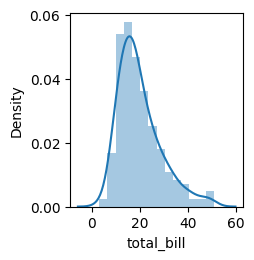

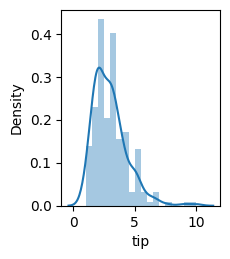

In [12]:
for i, col in enumerate(['total_bill','tip']):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
  plt.tight_layout()
  plt.show()


From the above plots, we can conclude that the data distribution is a little bit positively skewed. This is observed generally because maximum people spend in a certain range but some do such heavy expenditure that the distribution becomes positively skewed

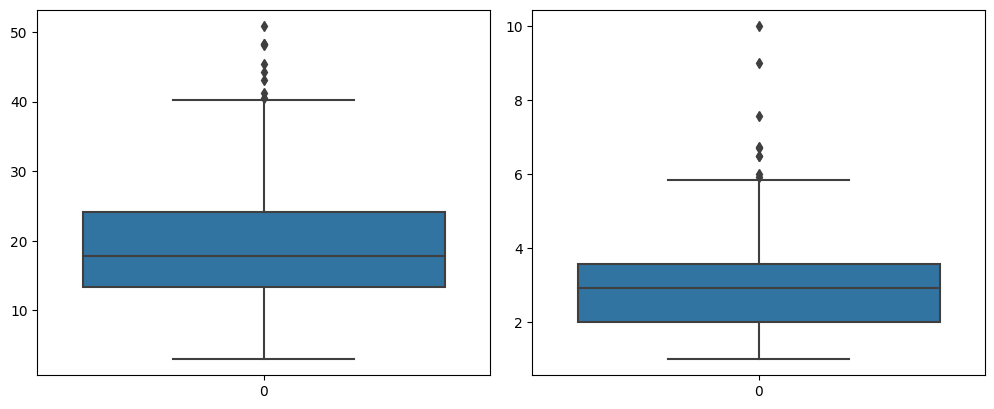

In [13]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(['total_bill', 'tip']):
  plt.subplot(2,3, i + 1)
  sb.boxplot(df[col])
plt.tight_layout()
plt.show()

From the above boxplots, we can say that there are outliers in the dataset. But we have very less amount of data already if we will drop more rows it would not be a good idea. But let’s check how many rows we will have to remove in order to get rid of the outliers.

In [14]:

df.shape, df[(df['total_bill']<45) & (df['tip']<7)].shape

((244, 7), (238, 7))

We will have to just lose 6 data points in order to get rid of most of the outliers so, let’s do this.

In [15]:
df = df[(df['total_bill']<45) & (df['tip']<7)]

Let’s draw the count plot for the categorical columns.

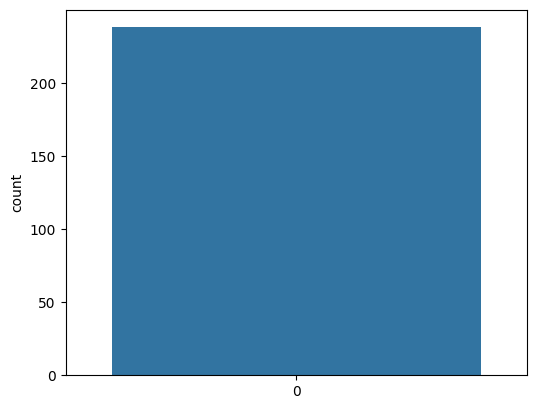

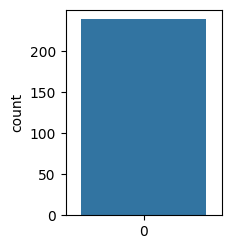

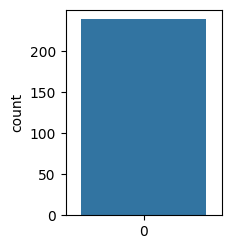

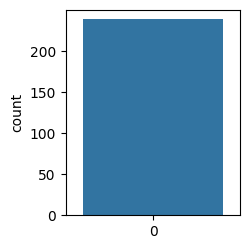

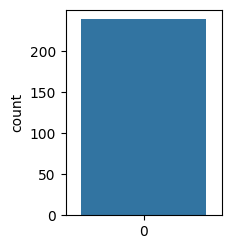

In [43]:
feat = df.loc[:,'sex':'size'].columns

plt.subplots(figsize=(15,8))
for i, col in enumerate(feat):
  plt.subplot(2,3, i + 1)
  sb.countplot(df[col])
  plt.tight_layout()
  plt.show()


Here we can draw some observations which are stated below:



*   Footfall on weekends is more than that on weekdays
*   People usually prefer dinner outside as compared to lunch.
*   People going alone to restaurants is as rare as people going with a family of 5 or 6 persons.







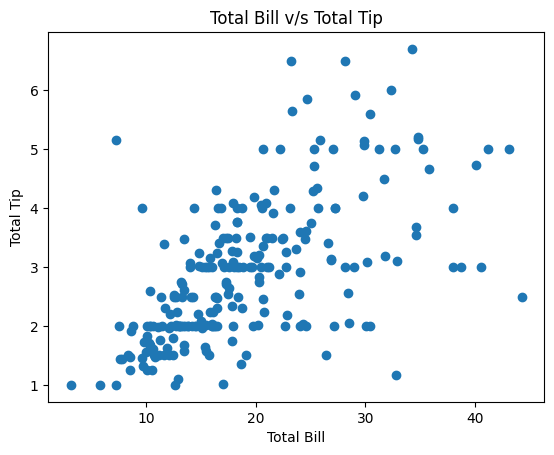

In [26]:
plt.scatter(df['total_bill'], df['tip'])
plt.title('Total Bill v/s Total Tip')
plt.xlabel('Total Bill')
plt.ylabel('Total Tip')
plt.show()

Let’s see what is the relation between the size of the family and the tip given

In [27]:
df.groupby(['size']).mean()

,total_bill,tip
size,,
1,7.242500,1.437500
2,16.448013,2.582308
3,21.899722,3.206667
4,27.137647,3.814706
5,30.068000,4.028000
6,30.383333,5.300000


Here we can derive one observation that the tip given on weekends is generally higher than that compared that given on weekdays.

In [35]:
le = LabelEncoder()

for col in df.columns:
  if df[col].dtype == object:
    df[col] = le.fit_transform(df[col])

df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4


Now all the columns have been converted to numerical form. Let’s draw a heatmap to analyze the correlation between the variables of the dataset.

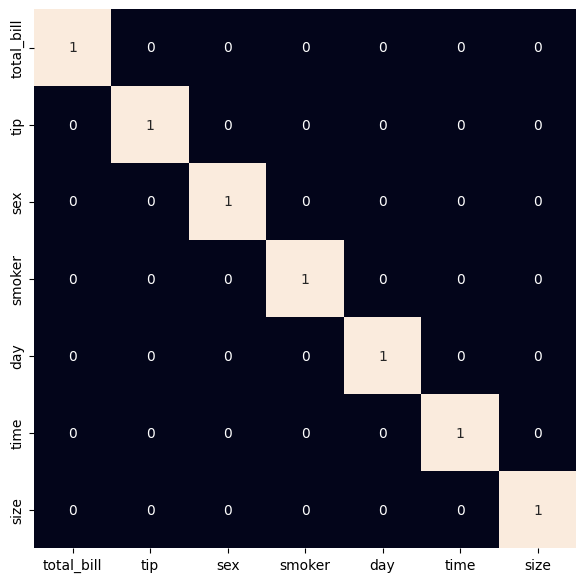

In [36]:
plt.figure(figsize=(7,7))
sb.heatmap(df.corr() > 0.7, annot = True, cbar = False)
plt.show()

From the above heatmap, it is certain that there are no highly correlated features in it.

**Model Development**


There are so many state-of-the-art ML models available in academia but some model fits better to some problem while some fit better than other. So, to make this decision we split our data into training and validation data. Then we use the validation data to choose the model with the highest performance.

In [37]:
features = df.drop('tip', axis=1)
target = df['tip']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=22)
X_train.shape, X_val.shape


((190, 6), (48, 6))

After dividing the data into training and validation data it is considered a better practice to achieve stable and fast training of the model.

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


Now let’s train some state-of-the-art machine learning models on the training data and then use the validation data for choosing the best out of them for prediction.

In [40]:
models = [LinearRegression(), XGBRegressor(), RandomForestRegressor(), AdaBoostRegressor()]

for i in range(4):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  pred_train = models[i].predict(X_train)
  print('Training Accuracy : ', mae(Y_train, pred_train))

  pred_val = models[i].predict(X_val)
  print('Validation Accuracy : ', mae(Y_val, pred_val))
  print()


LinearRegression() : 
Training Accuracy :  0.6866406322422778
Validation Accuracy :  0.7903774704017295

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.02728007923929315
Validation Accuracy :  0.7682166453202566

RandomForestRegressor() : 
Training Accuracy :  0.28141421052

Out of all the models RandomForestModel is giving the least value for the mean absolute error this means predictions made by this model are close to the real values as compared to the other model.

**Conclusion**

The dataset we have used here was small still the conclusion we drew from them were quite similar to what is observed in the real-life scenario. If we would have a bigger dataset then we will be able to learn even deeper patterns in the relation between the independent features and the tip given to the waiters.

